In [29]:
#1. Bibliotheken importieren
import mysql.connector as mysql
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly import tools
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
"""cursor.execute("SHOW DATABASES")

for x in cursor:
  print(x)"""

'cursor.execute("SHOW DATABASES")\n\nfor x in cursor:\n  print(x)'

In [4]:
#Read all the credentials from external file
credentials = pd.read_csv('../credentials/credentials.csv')

database_adress = credentials['Host'].iloc[0]
database_user = credentials['User'].iloc[0]
database_password = credentials['Password'].iloc[0]
database_name = credentials['Database'].iloc[0]

print(database_user)

darth_vader


In [5]:
#Connect to Database
db = mysql.connect(host=database_adress, user=database_user, passwd=database_password, database=database_name)
cursor = db.cursor()

#Form and execute query
query = "SELECT * FROM movies;" ## Read from DB
cursor.execute(query)

#Load query in Dataframe and print it out
all_movies = pd.DataFrame(list(cursor), columns=['id', 'title', 'year'])

all_movies.iloc[0:10].style.hide_index()


C:\Users\kluse\AppData\Local\Temp\ipykernel_11504\1500676116.py:12: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis='index')`



id,title,year
1,Toy Story (1995),1995
2,Jumanji (1995),1995
3,Grumpier Old Men (1995),1995
4,Waiting to Exhale (1995),1995
5,Father of the Bride Part II (1995),1995
6,Heat (1995),1995
7,Sabrina (1995),1995
8,Tom and Huck (1995),1995
9,Sudden Death (1995),1995
10,GoldenEye (1995),1995


In [6]:
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

In [7]:
db_connection_str = f"mysql+pymysql://{database_user}:{database_password}@{database_adress}/{database_name}"
db_connection = create_engine(db_connection_str)

In [8]:
all_movies = pd.read_sql('SELECT * FROM movies ORDER BY release_year', con=db_connection)

In [9]:
all_movies.head(400)

,movieId,title,release_year
0,183665,The Moors Murders,-1
1,183709,Harvest,-1
2,183755,Basmati Blues,-1
3,183837,The Favourite,-1
4,183855,Terminal,-1
...,...,...,...
395,187379,Colleurs d'affiches (1897),1897
396,192967,Football (1897),1897
397,167504,"Fifth Avenue, New York (1897)",1897
398,167508,Mr. Edison at Work in His Chemical Laboratory ...,1897


Text(0.5, 1.0, 'Released movies over time')

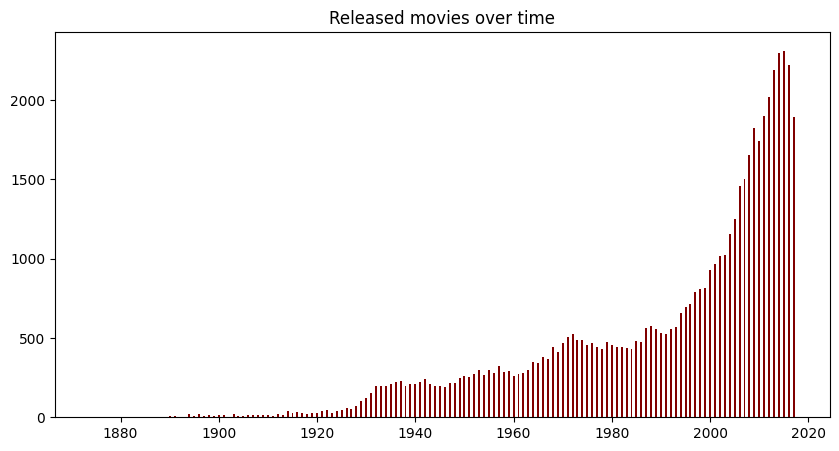

In [10]:
fig, ax = plt.subplots(figsize=(10,5))

year = pd.DataFrame(all_movies['release_year'].drop_duplicates())
count = all_movies.groupby(['release_year'])['movieId'].count()

year_count = pd.merge(year, count, on=["release_year", "release_year"])
year_count.rename(columns = {'movieId':'count'}, inplace=True)

year_count.drop(0, inplace=True)
year_count.drop(year_count.index[len(year_count)-1], inplace=True)

ax.bar(year_count['release_year'], year_count['count'], color ='maroon',
      width = 0.4)

ax.set_title("Released movies over time")
#ax.set_xlim(1850,2018)

In [11]:
year_count['release_year'].head()

1    1874
2    1878
3    1883
4    1887
5    1888
Name: release_year, dtype: int64

In [12]:
all_movies.groupby(['release_year']).head()#['movieId'].count()

,movieId,title,release_year
0,183665,The Moors Murders,-1
1,183709,Harvest,-1
2,183755,Basmati Blues,-1
3,183837,The Favourite,-1
4,183855,Terminal,-1
...,...,...,...
57237,183589,Fifty Shades Freed (2018),2018
57238,183591,Winning Ticket (2018),2018
57239,183611,Game Night (2018),2018
57240,183613,Thoroughbreds (2018),2018


Text(0.5, 1.0, 'Released movies over time')

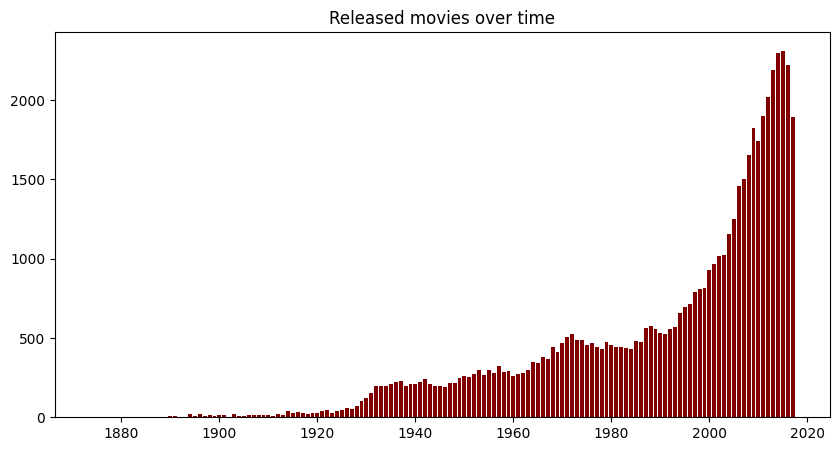

In [13]:
count = all_movies.groupby(['release_year'])['movieId'].count()

test_fig, test_ax = plt.subplots(figsize=(10,5))

count = count.drop([-1])
count = count.drop([2018])

test_ax.bar(count.index, count.values, color ='maroon')

test_ax.set_title("Released movies over time")

In [14]:
all_movies.groupby(['release_year']).head()

,movieId,title,release_year
0,183665,The Moors Murders,-1
1,183709,Harvest,-1
2,183755,Basmati Blues,-1
3,183837,The Favourite,-1
4,183855,Terminal,-1
...,...,...,...
57237,183589,Fifty Shades Freed (2018),2018
57238,183591,Winning Ticket (2018),2018
57239,183611,Game Night (2018),2018
57240,183613,Thoroughbreds (2018),2018


In [15]:
movies_with_genres = pd.read_sql("""SELECT m.movieId, m.title, g.genrename FROM movies as m 
INNER JOIN movies_genres as mg ON m.movieID = mg.movieId
INNER JOIN genres as g ON mg.genreId = g.genreId
ORDER BY m.movieId;""", con=db_connection)

In [16]:
genres = pd.read_sql("""SELECT * FROM genres;""", con=db_connection)

<BarContainer object of 19 artists>

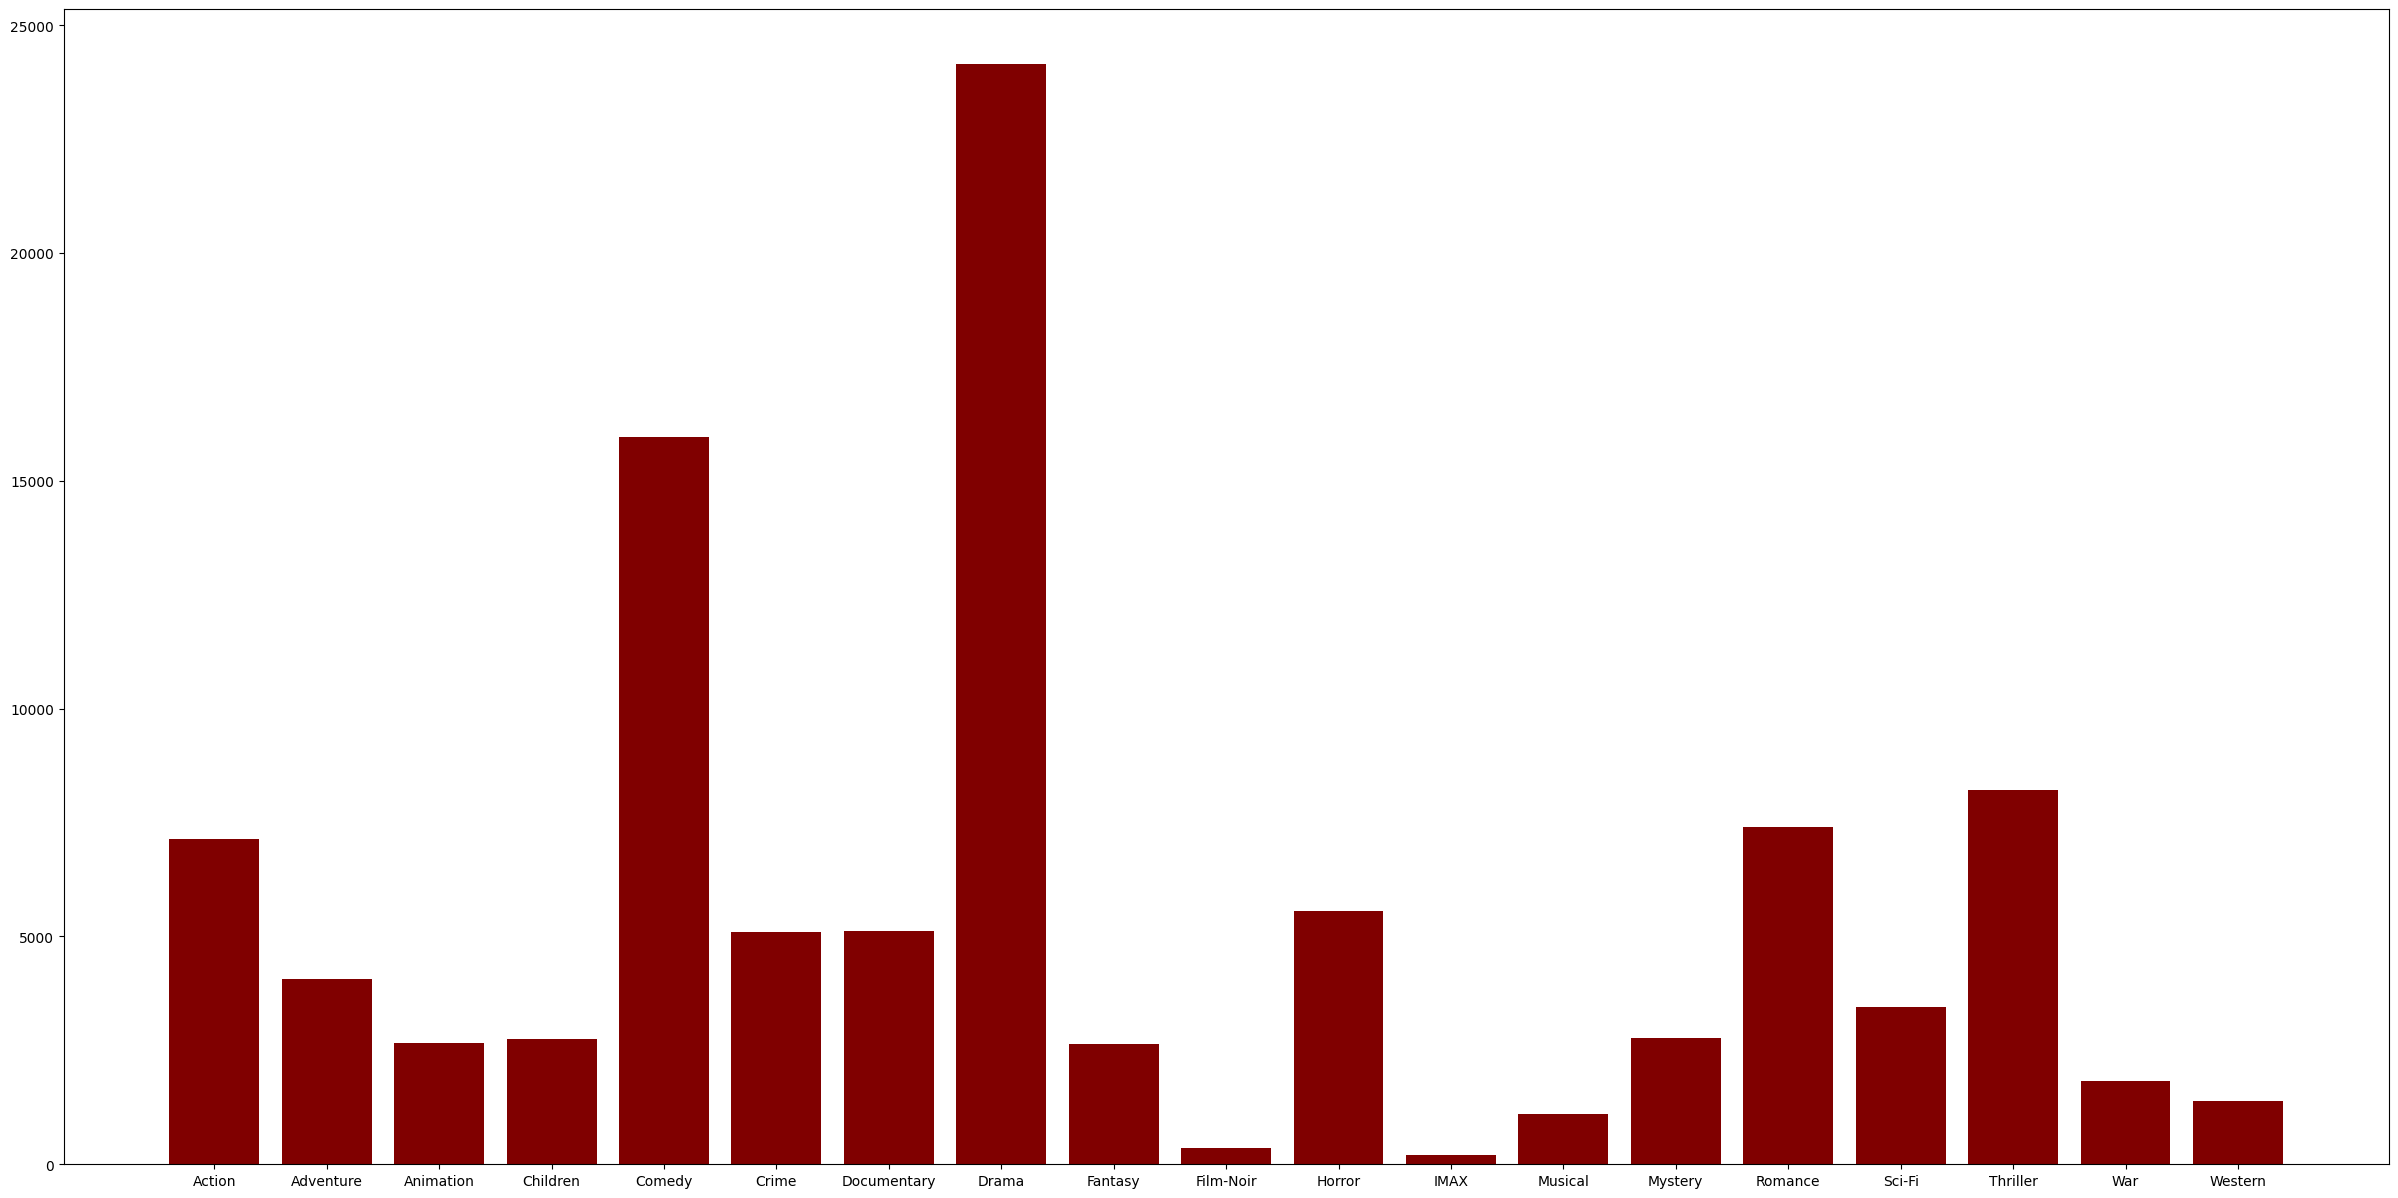

In [17]:
genres_count = movies_with_genres.groupby(['genrename'])['movieId'].count()

genres_count_fig, genres_count_ax = plt.subplots(figsize=(30,15))
#genres_count.head()
genres_count_ax.bar(genres_count.index, genres_count.values, color ='maroon')

In [18]:
genres.count()

genreId      19
genrename    19
dtype: int64

In [19]:
genres_df = pd.read_sql('SELECT mg.movieId,mg.genreId,g.genrename FROM movies_genres AS mg INNER JOIN genres AS g ON mg.genreId=g.genreId;', con=db_connection)

In [20]:
genres_df.groupby(['genrename'])['movieId'].count()

genrename
Action          7130
Adventure       4067
Animation       2663
Children        2749
Comedy         15956
Crime           5105
Documentary     5118
Drama          24144
Fantasy         2637
Film-Noir        364
Horror          5555
IMAX             197
Musical         1113
Mystery         2773
Romance         7412
Sci-Fi          3444
Thriller        8216
War             1820
Western         1378
Name: movieId, dtype: int64

## (1) Released movies over time (in Plotly)

In [21]:
all_movies = pd.read_sql('SELECT * FROM movies ORDER BY release_year', con=db_connection)

In [22]:
count = all_movies.groupby(['release_year'])['movieId'].count()

noyear_count = count[-1]
print(f'Movies without year: {noyear_count} or {((noyear_count / count.values.sum())*100):.2f}%')

count = count.drop([-1])
count = count.drop([2018])

count_df = count.to_frame()

fig1 = px.bar(count_df, x=count_df.index, y='movieId', title='Released movies over time',
labels={
                     "release_year": "Year of release",
                     "movieId": "Amount of movies"
                 },
                )
            
fig1.update_layout(
    xaxis=dict(
        title='Year of release',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Amount of movies',
        titlefont_size=16
    )
)
fig1.update_traces(marker_color='maroon')
fig1.show()

Movies without year: 323 or 0.56%


## (3) Genre share over time

Diagram Type: 100% Stacked Area Chart (https://codejock.com/products/chart/100-stacked-area-chart.asp)

**Challenges**
* [OK] Multiple genres
* [OK] Amount of genres to display

In [23]:
movies_genres = pd.read_sql('SELECT m.movieId, m.title, m.release_year, g.genreId, g.genrename FROM movies as m inner join movies_genres as mg on m.movieId=mg.movieId inner join genres as g on mg.genreId=g.genreId order by m.movieId', con=db_connection)
movies_genres[:10]

,movieId,title,release_year,genreId,genrename
0,1,Toy Story (1995),1995,9,Fantasy
1,1,Toy Story (1995),1995,5,Comedy
2,1,Toy Story (1995),1995,4,Children
3,1,Toy Story (1995),1995,3,Animation
4,1,Toy Story (1995),1995,2,Adventure
5,2,Jumanji (1995),1995,2,Adventure
6,2,Jumanji (1995),1995,4,Children
7,2,Jumanji (1995),1995,9,Fantasy
8,3,Grumpier Old Men (1995),1995,15,Romance
9,3,Grumpier Old Men (1995),1995,5,Comedy


In [24]:
print(f'Average genres per film: {len(movies_genres) / len(movies_genres.movieId.unique()):.2f}')
print('\nCheck total distribution')
genres_total_dist = movies_genres.genrename.value_counts().to_frame()
genres_total_dist['share'] = genres_total_dist.apply(lambda x: (x / genres_total_dist.genrename.sum()*100))
print(genres_total_dist)

Average genres per film: 1.89

Check total distribution
             genrename      share
Drama            24144  23.707544
Comedy           15956  15.667560
Thriller          8216   8.067478
Romance           7412   7.278012
Action            7130   7.001110
Horror            5555   5.454581
Documentary       5118   5.025481
Crime             5105   5.012716
Adventure         4067   3.993480
Sci-Fi            3444   3.381742
Mystery           2773   2.722872
Children          2749   2.699306
Animation         2663   2.614860
Fantasy           2637   2.589330
War               1820   1.787099
Western           1378   1.353090
Musical           1113   1.092880
Film-Noir          364   0.357420
IMAX               197   0.193439


In [25]:
#Calculating right share based on amount of genres
#For example: Jumanji (1995) has 3 genres assigned. Every genre should only count 1/3. 

#DISCLAIMER: can take up to 5min! not optimized yet!

genres_hist = pd.DataFrame(index=movies_genres.genrename.unique())

for year in range(1900,2018+1):
    q = movies_genres.query(f'release_year == {year}').copy()
    q['genre_vote'] = q['movieId'].apply(lambda x: (1/len(q.query(f'movieId == {x}'))))
    q = q.groupby(by='genrename').sum()
    q = q['genre_vote']
    q = q.round(decimals=2)
    genres_hist[year] = q


#old approach: absolute amount genre per year
"""
for year in range(1900,2018+1):
    genres_hist[year] = movies_genres.query(f'release_year == {year}').genrename.value_counts()
"""

"\nfor year in range(1900,2018+1):\n    genres_hist[year] = movies_genres.query(f'release_year == {year}').genrename.value_counts()\n"

In [26]:
#Fill na with 0 and set type int
genres_hist.fillna(0,inplace=True)
genres_hist = genres_hist.astype(int)

#calculate relative share for every year
for year in range(1900,2018+1):
    sum = genres_hist[year].sum()
    genres_hist[year] = genres_hist[year].apply(lambda x: round((x / sum)*100,2))

#Transpose for easier data access
genres_hist = genres_hist.T
genres_hist

,Fantasy,Comedy,Children,Animation,Adventure,Romance,Drama,Action,Thriller,Crime,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir
1900,0.00,14.29,0.00,0.00,0.00,28.57,14.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,42.86,0.00,0.00,0.00,0.0
1901,0.00,25.00,0.00,0.00,0.00,0.00,12.50,0.00,0.00,12.50,0.00,0.00,0.00,0.00,50.00,0.00,0.00,0.00,0.0
1902,50.00,0.00,0.00,0.00,0.00,0.00,50.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
1903,38.89,27.78,0.00,0.00,0.00,0.00,5.56,5.56,0.00,5.56,5.56,0.00,0.00,0.00,11.11,0.00,0.00,0.00,0.0
1904,33.33,33.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,33.33,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014,1.46,17.95,2.17,1.98,2.12,5.18,25.92,4.67,8.34,2.92,6.03,1.60,2.83,0.19,15.17,0.80,0.24,0.42,0.0
2015,1.48,18.23,2.72,2.19,2.34,4.72,25.38,4.53,8.97,2.39,7.16,1.86,3.10,0.00,13.88,0.76,0.00,0.29,0.0
2016,1.57,19.15,2.16,2.31,1.96,5.11,25.63,5.25,9.33,2.36,6.19,1.72,2.41,0.00,14.04,0.59,0.00,0.25,0.0
2017,1.48,18.71,1.71,2.28,1.88,4.51,25.39,5.53,8.84,2.74,6.90,1.83,3.31,0.00,13.69,0.74,0.00,0.46,0.0


In [31]:
pio.templates.default = "plotly_dark"

top10genres = genres_hist.loc[2018].sort_values(ascending=False).head(10).index.to_list()

color_seq = px.colors.qualitative.G10
color_seq_count = 0

fig3 = go.Figure()
for genre in top10genres:
    color = color_seq[color_seq_count]
    color_seq_count+=1
    fig3.add_trace(go.Scatter(x=genres_hist.index,
                         y=genres_hist[genre],
                         #fill='tozeroy', #fill down to xaxis
                         #fillcolor='orange',
                         mode='lines',
                         line={'dash': 'solid', 'color': color},
                         name=genre,
                         stackgroup='one',
                         ))
fig3.update_layout(
    xaxis=dict(
        title='Time in years',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Share of genre [%]',
        titlefont_size=16
    ),
    yaxis_range=(0,100),
    xaxis_range=(1900,2018),
    title="Genre popularity over time"
)
fig3.add_vrect(x0=1900,x1=1920,line_width=0,fillcolor='black',opacity=0.4,annotation_text="not enough data",annotation_position="bottom left",
    annotation=dict(font_size=18,font_color='white')
)
fig3.show()